In [22]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/team_a/data/xy_data"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['user_info_l.csv',
 'user_info_s.csv',
 'mobile.csv',
 'application.csv',
 'internal_score.csv',
 'pty3rd.csv',
 'inquiry.csv',
 'account.csv',
 'readme.txt',
 'internal data_clean.csv',
 'account_cleaned.csv',
 'pty3rd_cleaned.csv',
 'application_cleaned.csv',
 'mobile_cleaned.csv',
 'inquiry_cleaned.csv',
 'zero_features_drop (2).gsheet',
 'basic_universe.csv',
 'continuous.csv',
 'categorical.csv',
 'zero_features_drop (1).gsheet',
 'application (1).gsheet',
 'application.gsheet',
 'application_oot.csv',
 'inquiry_oot.csv',
 'user_info_l_oot.csv',
 'mobile_oot.csv',
 'internal_score_oot.csv',
 'pty3rd_oot.csv',
 'account_oot.csv',
 'zero_features_drop.csv',
 'zero_features_drop.gsheet',
 'var_description.csv',
 'lgbm_importances-01.png',
 'merge_cleaned.csv',
 'Model_based_Feature_Selection_Lasso.csv',
 'Model_based_Feature_Selection_LGBM.csv',
 'Model_based_Feature_Selection_Lasso_50percent.csv',
 'Model_based_Feature_Selection_Lasso_Basic_Universe.csv',
 'data_bin.csv',
 'data_bi

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import MinMaxScaler

# filter warnings
import warnings
warnings.filterwarnings("ignore")

In [24]:
selected=pd.read_csv('Lasso_Feature_Selection_cleaned_v5.csv') 
oot=pd.read_csv('Lasso_Feature_Selection_cleaned_v5_oot.csv')

In [25]:
print(selected.label.sum()/selected.shape[0])
print(oot.label.sum()/oot.shape[0])

0.15375686369509045
0.05797474049554906


In [26]:
print(selected.isnull().values.any())
print(oot.isnull().values.any())

False
False


In [27]:
#look for datatype object
print(selected.select_dtypes(include='object').columns)
print(oot.select_dtypes(include='object').columns)

Index([], dtype='object')
Index([], dtype='object')


In [28]:
print(selected.shape)
print(oot.shape)

(99072, 70)
(31117, 70)


In [29]:
y = selected['label']
X = selected.drop(columns=['applied_id','label'])

In [30]:
X

,AC7,AC11,AC12,AC14,IN1,IN2,IN6,IN13,IN15,IN16,IN27,IN29,IN30,IN36,P11,P13,P42,P46,P49,P50,P76,P79,P85,P92,P121,P123,P125,P157,P165,IS2,IS8,IS11,MB2,MB13,MB9_h5,IS9_1.0,IS9_4.0,AC2_0.0,AC2_2.0,AC2_1.0,AC2_5.0,AC3_8.0,AC3_1.0,AC3_0.0,AP1_male,MB12_wifi,AP4_bin,AC14_bin,IN1_bin,IN3_bin,IN5_bin,IN9_bin,IN13_bin,IN14_bin,IN17_bin,IN32_bin,P4_bin,P8_bin,IS1_bin,IS3_bin,MB8_bin,AC2_notnull,AC11_notnull,AC12_notnull,IN17_notnull,P1_notnull,MB8_notnull,AP5 AP7
0,9403.0,8.0,209370.0,135306.0,2.0,2.0,4.0,13.0,5.0,0.0,15.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1780.427768,2555.205047,3104.044948,1.598949e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,8,5,1,0,4,5,6,5,2,6,0,0,2,0,2,1,1,1,1,0,1,10140.0
1,0.0,1.0,2100.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.186916,2003.414912,2064.977210,6.398947e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6,0,0,0,0,0,1,0,0,1,0,0,5,2,1,1,1,1,1,0,1,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2131.002825,1980.940417,2362.578154,6.398947e+10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0,0,0,0,1,1,0,0,0,0,0,5,4,2,0,1,1,1,0,0,0.0
3,0.0,0.0,0.0,0.0,2.0,2.0,5.0,6.0,2.0,0.0,6.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2222.222222,2651.933700,2646.717142,6.398947e+10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0,1,0,4,3,4,4,3,4,0,1,7,7,2,0,1,1,1,1,0,0.0
4,0.0,0.0,0.0,0.0,3.0,1.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1821.946170,1651.676206,2515.135550,2.559895e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,0,2,0,3,3,3,0,0,0,0,0,4,4,1,1,1,1,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99067,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2293.750000,2561.403509,2640.073746,6.398947e+10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,1,1,1,0,0,0,0,0,6,6,2,0,1,1,1,0,0,0.0
99068,5469.0,12.0,87888.0,44993.0,2.0,0.0,5.0,23.0,5.0,0.0,14.0,0.0,0.0,54.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1535.796358,2145.435792,1438.943111,6.398949e+10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,4,1,0,5,6,7,6,0,7,1,1,1,4,2,1,1,1,1,1,1,6048.0
99069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2527.551588,1871.768356,1989.743229,2.559370e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,0,0,0,0,0,0,0,0,0,0,0,8,5,4,0,1,1,1,0,1,0.0
99070,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,8.0,0.0,6.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1722.321775,2777.232581,3238.221568,6.398947e+10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,0,2,0,2,2,2,0,0,3,0,0,0,4,1,0,1,1,1,1,1,0.0


In [31]:
y_oot=oot['label']
X_oot = oot.drop(columns=['applied_id','label'])

## Models on Select Features






### Define functions

#### Basic Models

In [32]:
def tuning(model, parameters):
  roc=[]
  tprs = []
  pr=[]
  prs = []
  mean_fpr = np.linspace(0,1,100)
  mean_precision = np.linspace(0,1,100)
  i=1
  skf=StratifiedKFold(n_splits=5,random_state=42)
  skf.get_n_splits(X,y)

  for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]
  
    #model
    clf = GridSearchCV(model,scoring='roc_auc', param_grid=parameters, cv=2)
    clf.fit(X_train, y_train)
    print("best parameters: {}".format(clf.best_params_))
    clf_proba=clf.predict_proba(X_test)[:,1]

    #roc_auc score
    roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
    clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
    prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
    pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
    clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
    tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))


    print('ROC AUC score:',roc_score)
    print('PR AUC score:',pr_score)
    roc.append(roc_score)
    pr.append(pr_score)
    i+=1


  print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
  ns_probs = [0 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  mean_fpr=np.linspace(0,1,100)
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the plot
  plt.show()
  # summarize scores
  print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 
  mean_precision = np.linspace(0,1,100)
  mean_recall = np.mean(prs, axis=0)
  mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  # show the plot
  plt.show()
  # summarize scores
  print('PR AUC=%.3f' % (mean_auc))



#### Oversampling Models

In [33]:
def tuning_oversampling(model, parameters,over_method):
  roc=[]
  tprs = []
  pr=[]
  prs = []
  mean_fpr = np.linspace(0,1,100)
  mean_precision = np.linspace(0,1,100)
  i=1
  skf=StratifiedKFold(n_splits=5,random_state=42)
  skf.get_n_splits(X,y)

  for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y.iloc[train_index], y.iloc[test_index]
    
    over = over_method(sampling_strategy=0.5,random_state=42)
    X_train_over, y_train_over = over.fit_resample(X_train, y_train)
    X_train_over=pd.DataFrame(X_train_over)
    y_train_over=pd.DataFrame(y_train_over)

    #model
    clf = GridSearchCV(model,scoring='roc_auc', param_grid=parameters, cv=2)
    clf.fit(X_train_over, y_train_over)
    print("best parameters: {}".format(clf.best_params_))
    clf_proba=clf.predict_proba(X_test)[:,1]

    #roc_auc score
    roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
    clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
    prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
    pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
    clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
    tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))


    print('ROC AUC score:',roc_score)
    print('PR AUC score:',pr_score)
    roc.append(roc_score)
    pr.append(pr_score)
    i+=1


  print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
  ns_probs = [0 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  mean_fpr=np.linspace(0,1,100)
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  # show the plot
  plt.show()
  # summarize scores
  print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 
 

  mean_precision = np.linspace(0,1,100)
  mean_recall = np.mean(prs, axis=0)
  mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  # show the plot
  plt.show()
  # summarize scores
  print('PR AUC=%.3f' % (mean_auc))

#### Undersampling Models

In [34]:
def tuning_undersampling(model, parameters,under_method):
  roc=[]
  tprs = []
  pr=[]
  prs = []
  mean_fpr = np.linspace(0,1,100)
  mean_precision = np.linspace(0,1,100)
  i=1
  skf=StratifiedKFold(n_splits=5,random_state=42)
  skf.get_n_splits(X,y)

  for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]
    
    under = under_method(sampling_strategy=0.5,random_state=42)
    X_train_under, y_train_under = under.fit_resample(X_train, y_train)
    X_train_under=pd.DataFrame(X_train_under)
    y_train_under=pd.DataFrame(y_train_under)

    #model
    clf = GridSearchCV(model,scoring='roc_auc', param_grid=parameters, cv=2)
    clf.fit(X_train_under, y_train_under)
    print("best parameters: {}".format(clf.best_params_))
    clf_proba=clf.predict_proba(X_test)[:,1]

    #roc_auc score
    roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
    clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
    prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
    pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
    clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
    tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))


    print('ROC AUC score:',roc_score)
    print('PR AUC score:',pr_score)
    roc.append(roc_score)
    pr.append(pr_score)
    i+=1


  print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
  ns_probs = [0 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  mean_fpr=np.linspace(0,1,100)
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  # show the plot
  plt.show()
  # summarize scores
  print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 

  mean_precision = np.linspace(0,1,100)
  mean_recall = np.mean(prs, axis=0)
  mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  # show the plot
  plt.show()
  # summarize scores
  print('PR AUC=%.3f' % (mean_auc))

#### Voting/ Stacking

In [35]:
def no_tuning(clf):
  roc=[]
  tprs = []
  pr=[]
  prs = []
  mean_fpr = np.linspace(0,1,100)
  mean_precision = np.linspace(0,1,100)
  i=1
  skf=StratifiedKFold(n_splits=5,random_state=42)
  skf.get_n_splits(X,y)

  for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]
  
    #model
    clf.fit(X_train, y_train)
    clf_proba=clf.predict_proba(X_test)[:,1]

    #roc_auc score
    roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
    clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
    prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
    pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
    clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
    tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))


    print('ROC AUC score:',roc_score)
    print('PR AUC score:',pr_score)
    roc.append(roc_score)
    pr.append(pr_score)
    i+=1


  print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
  ns_probs = [0 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  mean_fpr=np.linspace(0,1,100)
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the plot
  plt.show()
  # summarize scores
  print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 
  mean_precision = np.linspace(0,1,100)
  mean_recall = np.mean(prs, axis=0)
  mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  # show the plot
  plt.show()
  # summarize scores
  print('PR AUC=%.3f' % (mean_auc))



#### ANN Model

In [36]:
def ANN(clf,a,b):
  roc=[]
  tprs = []
  pr=[]
  prs = []
  mean_fpr = np.linspace(0,1,100)
  mean_precision = np.linspace(0,1,100)
  i=1
  skf=StratifiedKFold(n_splits=5,random_state=42)
  skf.get_n_splits(X,y)

  for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]

    #standardize the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #model
    clf.fit(X_train, y_train, epochs=a, batch_size=b)
    clf_proba=clf.predict_proba(X_test)

    #roc_auc score
    roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
    clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
    prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
    pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
    clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
    tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))
 

    print('ROC AUC score:',roc_score)
    print('PR AUC score:',pr_score)
    roc.append(roc_score)
    pr.append(pr_score)
    i+=1


  print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
  ns_probs = [0 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  mean_fpr=np.linspace(0,1,100)
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the plot
  plt.show()
  # summarize scores
  print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 
  mean_precision = np.linspace(0,1,100)
  mean_recall = np.mean(prs, axis=0)
  mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  # show the plot
  plt.show()
  # summarize scores
  print('PR AUC=%.3f' % (mean_auc))


#### ROC PR for oot

In [37]:
def roc_pr(actual,pred):
  # calculate score
  auc_score = roc_auc_score(actual,pred)
 
  # calculate roc curves
  fpr, tpr, _ = roc_curve(actual,pred)
  # plot the roc curve for the model
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.plot(fpr, tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  # show the plot
  plt.show()
  # summarize score
  print('ROC AUC=%.3f' % (auc_score))

  precision, recall, _ = precision_recall_curve(actual,pred)
  pr_auc = auc(recall, precision)
  
  # plot the precision-recall curves
  no_skill = len(y_oot[y_oot==1]) / len(y_oot)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(recall, precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision') 
  # show the plot
  plt.show()
  print('PR AUC=%.3f' % (pr_auc))

### GBM


1 of KFold 5
best parameters: {'max_depth': 4, 'n_estimators': 160}
ROC AUC score: 0.6990063688128982
PR AUC score: 0.2708624316491486
2 of KFold 5
best parameters: {'max_depth': 4, 'n_estimators': 80}
ROC AUC score: 0.6946898596604845
PR AUC score: 0.26150243790605465
3 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.6862507168610636
PR AUC score: 0.2608167816686286
4 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 160}
ROC AUC score: 0.6928249976192027
PR AUC score: 0.26760363554102257
5 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.6986427478253296
PR AUC score: 0.2637257412340325
Mean ROC AUC Score 0.694 
Mean PR AUC Score 0.265


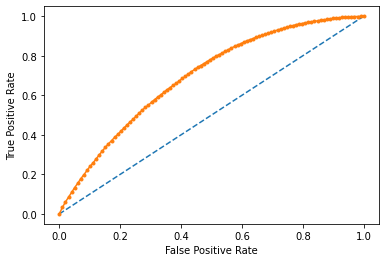

ROC AUC=0.694


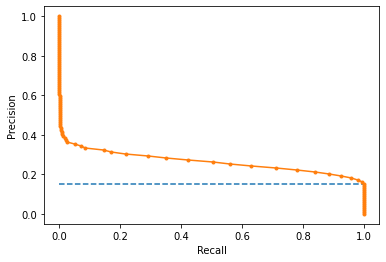

PR AUC=0.265


In [ ]:
parameters= {'n_estimators': range(20,200,20),'max_depth':[2,3,4]}
model=GradientBoostingClassifier()
tuning(model,parameters)

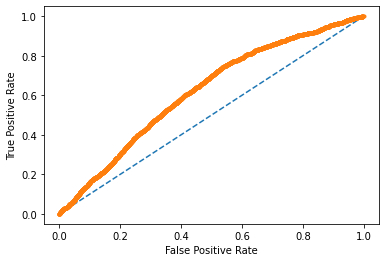

ROC AUC=0.621


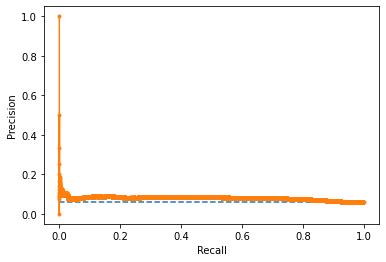

PR AUC=0.080


In [ ]:
gbm = GradientBoostingClassifier(max_depth=3,n_estimators=180).fit(X, y)
y_oot_pred = gbm.predict_proba(X_oot)[:, 1] # y_pred 
roc_pr(y_oot,y_oot_pred)

### Random Forest

1 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 80}
ROC AUC score: 0.6932406922589357
PR AUC score: 0.2631579201864942
2 of KFold 5
best parameters: {'max_depth': 11, 'n_estimators': 80}
ROC AUC score: 0.687201675969606
PR AUC score: 0.2509693509804556
3 of KFold 5
best parameters: {'max_depth': 9, 'n_estimators': 80}
ROC AUC score: 0.6815821234018272
PR AUC score: 0.25751679603104904
4 of KFold 5
best parameters: {'max_depth': 8, 'n_estimators': 80}
ROC AUC score: 0.6837083552356239
PR AUC score: 0.2573851713439361
5 of KFold 5
best parameters: {'max_depth': 8, 'n_estimators': 80}
ROC AUC score: 0.6899760584993209
PR AUC score: 0.2602962021961721
Mean ROC AUC Score 0.687 
Mean PR AUC Score 0.258


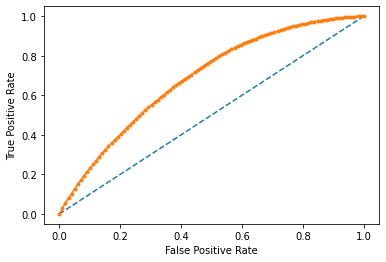

ROC AUC=0.687


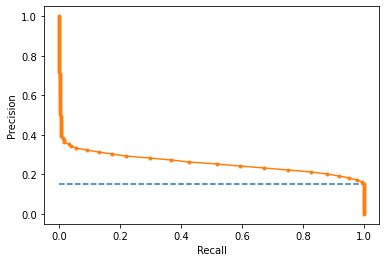

PR AUC=0.258


In [ ]:
parameters= {'n_estimators': range(20,100,20),'max_depth':[8,9,10,11]}
model=RandomForestClassifier()
tuning(model,parameters)

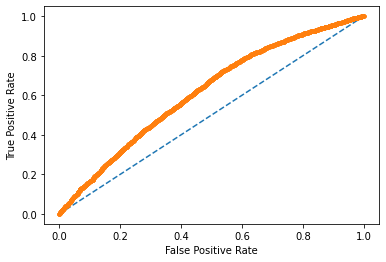

ROC AUC=0.617


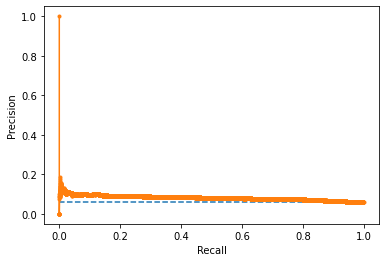

PR AUC=0.082


In [ ]:
rf=RandomForestClassifier(max_depth=9, n_estimators=80).fit(X,y)
y_oot_pred = rf.predict_proba(X_oot)[:, 1] # y_pred 
roc_pr(y_oot,y_oot_pred)

### GBM with Oversampling

1 of KFold 5
best parameters: {'max_depth': 4, 'n_estimators': 100}
ROC AUC score: 0.6954512592319563
PR AUC score: 0.27082482681640463
2 of KFold 5
best parameters: {'max_depth': 4, 'n_estimators': 100}
ROC AUC score: 0.6912787645274917
PR AUC score: 0.2592444980972448
3 of KFold 5
best parameters: {'max_depth': 4, 'n_estimators': 100}
ROC AUC score: 0.6846016746171962
PR AUC score: 0.2547228225980795
4 of KFold 5
best parameters: {'max_depth': 4, 'n_estimators': 100}
ROC AUC score: 0.6887858850363134
PR AUC score: 0.261997462248352
5 of KFold 5
best parameters: {'max_depth': 4, 'n_estimators': 100}
ROC AUC score: 0.6961486962942264
PR AUC score: 0.26372050864878216
Mean ROC AUC Score 0.691 
Mean PR AUC Score 0.262


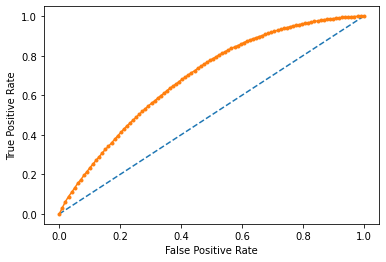

ROC AUC=0.691


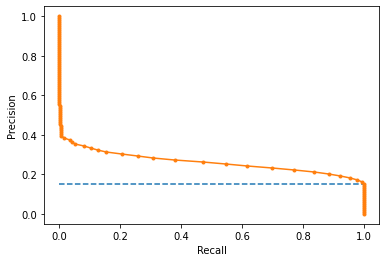

PR AUC=0.263


In [ ]:
parameters= {'n_estimators': range(100,200,20),'max_depth':[4,5,6]}
model=GradientBoostingClassifier()
tuning_oversampling(model,parameters,SMOTE)

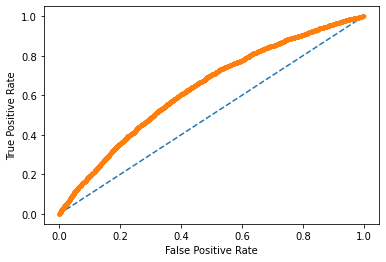

ROC AUC=0.635


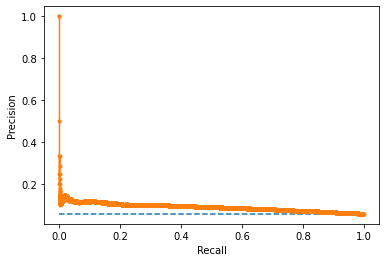

PR AUC=0.091


In [ ]:
over = SMOTE(sampling_strategy=0.5,random_state=42)
X_over, y_over = over.fit_resample(X, y)
X_over=pd.DataFrame(X_over)
y_over=pd.DataFrame(y_over)
gbm_over = GradientBoostingClassifier(max_depth=4,n_estimators=100).fit(X_over, y_over)
y_oot_pred = gbm_over.predict_proba(X_oot)[:, 1] # y_pred 
roc_pr(y_oot,y_oot_pred)

### GBM with Undersampling

1 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.698467567273028
PR AUC score: 0.2659513530309039
2 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 160}
ROC AUC score: 0.6949873518596692
PR AUC score: 0.2621499539640774
3 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 160}
ROC AUC score: 0.6858590869444448
PR AUC score: 0.25753348953718613
4 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 120}
ROC AUC score: 0.6914008657957127
PR AUC score: 0.26653932685753656
5 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 140}
ROC AUC score: 0.6950532065109793
PR AUC score: 0.2636037406857027
Mean ROC AUC Score 0.693 
Mean PR AUC Score 0.263


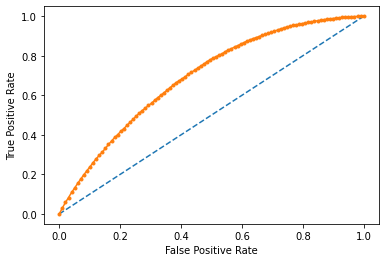

ROC AUC=0.693


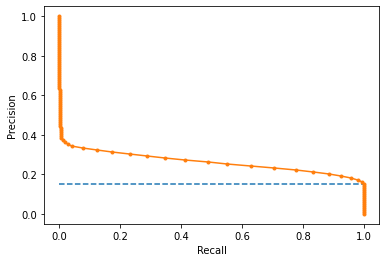

PR AUC=0.263


In [ ]:
parameters= {'n_estimators': range(20,200,20),'max_depth':[2,3,4]}
model=GradientBoostingClassifier()
tuning_undersampling(model,parameters,RandomUnderSampler)

ROC AUC=0.632


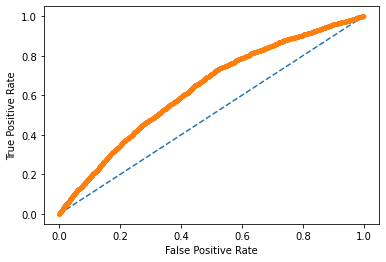

pr_auc=0.088


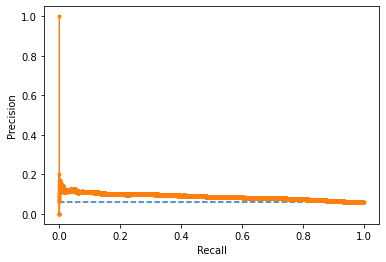

In [ ]:
under = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
X_under, y_under = under.fit_resample(X, y)
X_under=pd.DataFrame(X_under)
y_under=pd.DataFrame(y_under)
gbm_under = GradientBoostingClassifier(max_depth=3,n_estimators=180).fit(X_under, y_under)
y_oot_pred = gbm_under.predict_proba(X_oot)[:, 1] # y_pred 
roc_pr(y_oot,y_oot_pred)

### Random Forest with Oversampling

1 of KFold 5
best parameters: {'max_depth': 11, 'n_estimators': 180}
ROC AUC score: 0.6825652836791036
PR AUC score: 0.24981227780414614
2 of KFold 5
best parameters: {'max_depth': 11, 'n_estimators': 140}
ROC AUC score: 0.6824893228103228
PR AUC score: 0.24827074569483248
3 of KFold 5
best parameters: {'max_depth': 11, 'n_estimators': 140}
ROC AUC score: 0.6747355974467248
PR AUC score: 0.24006542140338333
4 of KFold 5
best parameters: {'max_depth': 11, 'n_estimators': 120}
ROC AUC score: 0.6804638239425501
PR AUC score: 0.24986312699135
5 of KFold 5
best parameters: {'max_depth': 11, 'n_estimators': 180}
ROC AUC score: 0.6894098262080666
PR AUC score: 0.25335513688669836
Mean ROC AUC Score 0.682 
Mean PR AUC Score 0.248


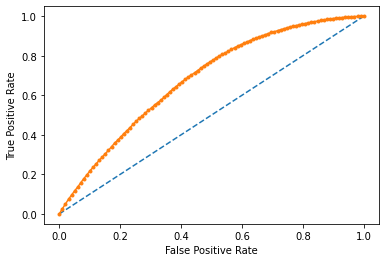

ROC AUC=0.682


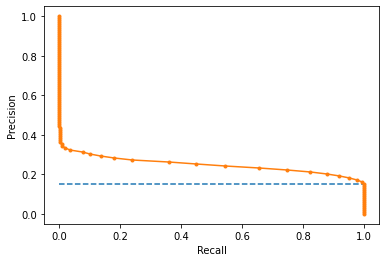

PR AUC=0.249


In [ ]:
parameters= {'n_estimators': range(20,200,20),'max_depth':[8,9,10,11]}
model=RandomForestClassifier()
tuning_oversampling(model,parameters,SMOTE)

ROC AUC=0.624


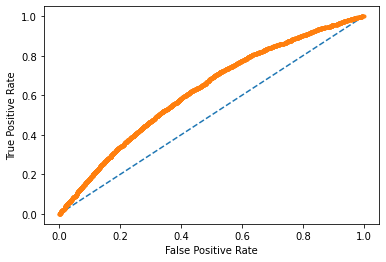

pr_auc=0.085


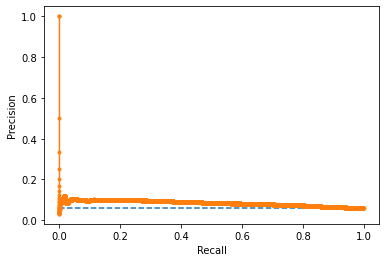

In [ ]:
over = SMOTE(sampling_strategy=0.5,random_state=42)
X_over, y_over = over.fit_resample(X, y)
X_over=pd.DataFrame(X_over)
y_over=pd.DataFrame(y_over)
rf_over = RandomForestClassifier(max_depth=11,n_estimators=140).fit(X_over, y_over)
y_oot_pred = rf_over.predict_proba(X_oot)[:, 1] # y_pred 
roc_pr(y_oot,y_oot_pred)

### Random Forest with Undersampling

1 of KFold 5
best parameters: {'max_depth': 9, 'n_estimators': 80}
ROC AUC score: 0.6919721790235421
PR AUC score: 0.2608861834184215
2 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 80}
ROC AUC score: 0.6895418716037799
PR AUC score: 0.2540961320993904
3 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 80}
ROC AUC score: 0.6818413570391573
PR AUC score: 0.25794412657511223
4 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 80}
ROC AUC score: 0.6857807550447841
PR AUC score: 0.2561773013178046
5 of KFold 5
best parameters: {'max_depth': 9, 'n_estimators': 80}
ROC AUC score: 0.6930183395004336
PR AUC score: 0.2601406128049573
Mean ROC AUC Score 0.688 
Mean PR AUC Score 0.258


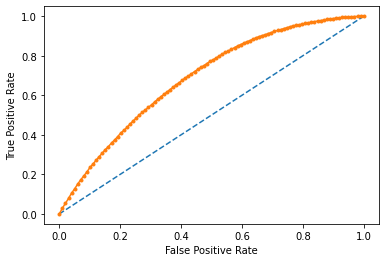

ROC AUC=0.688


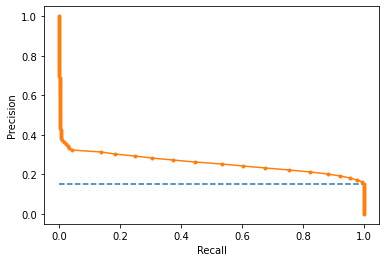

PR AUC=0.258


In [ ]:
parameters= {'n_estimators': range(20,100,20),'max_depth':[8,9,10]}
model=RandomForestClassifier()
tuning_undersampling(model,parameters,RandomUnderSampler)

ROC AUC=0.629


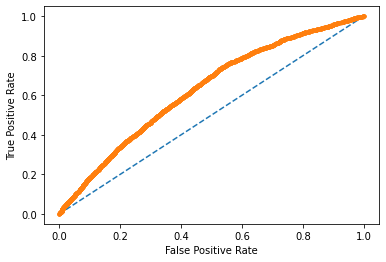

pr_auc=0.087


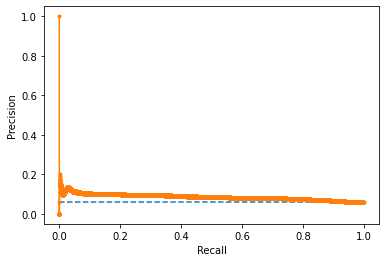

In [ ]:
under = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
X_under, y_under = under.fit_resample(X, y)
X_under=pd.DataFrame(X_under)
y_under=pd.DataFrame(y_under)
rf_under = RandomForestClassifier(max_depth=10,n_estimators=180).fit(X_under, y_under)
y_oot_pred = rf_under.predict_proba(X_oot)[:, 1] # y_pred 
roc_pr(y_oot,y_oot_pred)

### Voting model based on GBM and Random Forest

In [ ]:
# Build multiple classification models
gb = GradientBoostingClassifier(n_estimators=180, max_depth=3,random_state=42) #gradient boosting
rf = RandomForestClassifier(n_estimators=80,max_depth=9,random_state=42) # Random Forest

1 of KFold 5
ROC AUC score: 0.698058658623048
PR AUC score: 0.27031565838800675
2 of KFold 5
ROC AUC score: 0.6939144657521977
PR AUC score: 0.26160003499748313
3 of KFold 5
ROC AUC score: 0.68574478651971
PR AUC score: 0.2614117192278247
4 of KFold 5
ROC AUC score: 0.6918848763927664
PR AUC score: 0.2673081038815047
5 of KFold 5
ROC AUC score: 0.6982241210472501
PR AUC score: 0.26401906516538154
Mean ROC AUC Score 0.694 
Mean PR AUC Score 0.265


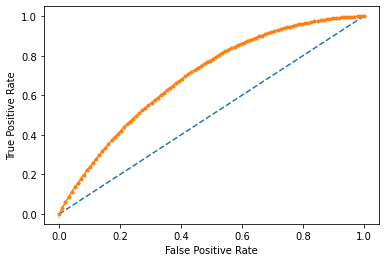

ROC AUC=0.694


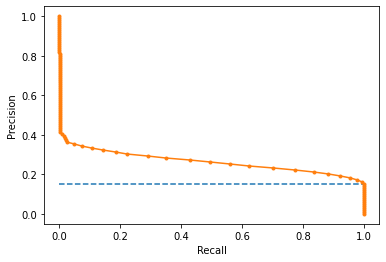

PR AUC=0.265


In [ ]:
from sklearn.ensemble import VotingClassifier
clf = VotingClassifier(
    estimators=[('gb', gb), ('rf', rf)],
    voting='soft') #predicts the class label based on the argmax of the sums of the predicted probabilities
  
no_tuning(clf)

ROC AUC=0.631


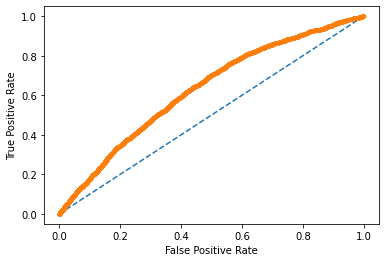

pr_auc=0.087


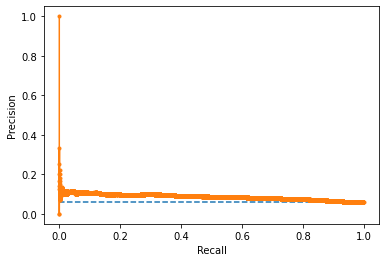

In [ ]:
y_oot_pred = clf.predict_proba(X_oot)[:, 1] # y_pred 
roc_pr(y_oot,y_oot_pred)

### Stack model based on GBM and Random Forest

In [24]:
# Build multiple classification models
gb = GradientBoostingClassifier(n_estimators=180, max_depth=3,random_state=42) #gradient boosting
rf = RandomForestClassifier(n_estimators=80,max_depth=9,random_state=42) # Random Forest


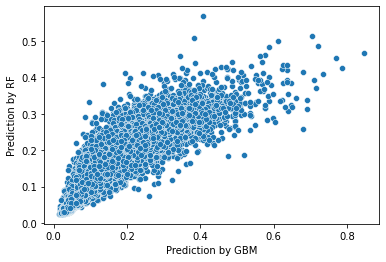

In [25]:
gb.fit(X,y)
rf.fit(X,y)
gb_proba=gb.predict_proba(X)[:,1]
rf_proba=rf.predict_proba(X)[:,1]

fig = sns.scatterplot(x=gb_proba, y=rf_proba)
plt.xlabel("Prediction by GBM")
plt.ylabel("Prediction by RF")
plt.show(fig)

1 of KFold 5
ROC AUC score: 0.6974589768249084
PR AUC score: 0.26970984820228466
2 of KFold 5
ROC AUC score: 0.6932679665363504
PR AUC score: 0.26124602654408735
3 of KFold 5
ROC AUC score: 0.685159984089741
PR AUC score: 0.26101760899308735
4 of KFold 5
ROC AUC score: 0.6909609077791923
PR AUC score: 0.2666613144472646
5 of KFold 5
ROC AUC score: 0.6977371344536447
PR AUC score: 0.26380742366285775
Mean ROC AUC Score 0.693 
Mean PR AUC Score 0.264


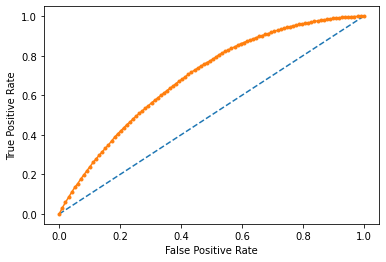

ROC AUC=0.693


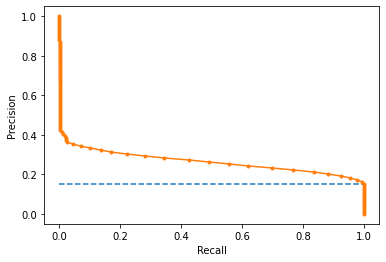

PR AUC=0.265


In [ ]:
estimators=[('gb', gb), ('rf', rf)]
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=estimators,final_estimator=LogisticRegression())

#use a new model to learn how to best combine the predictions from models trained before
no_tuning(clf)

ROC AUC=0.631


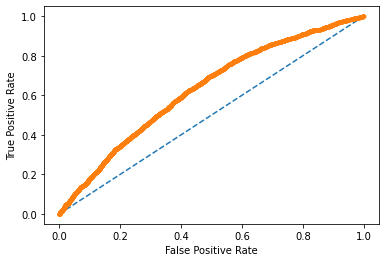

pr_auc=0.087


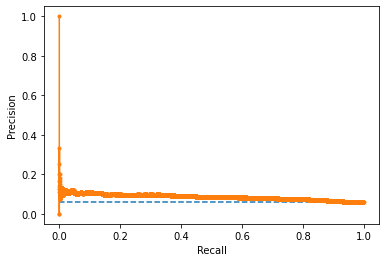

In [ ]:
y_oot_pred = clf.predict_proba(X_oot)[:, 1] # y_pred 
roc_pr(y_oot,y_oot_pred)

### ANN

In [ ]:
X.shape

(99072, 68)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               6900      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6

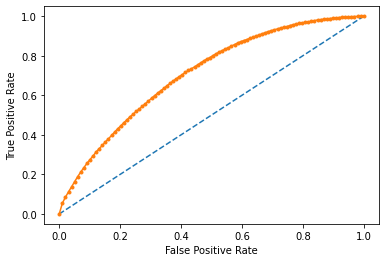

ROC AUC=0.709


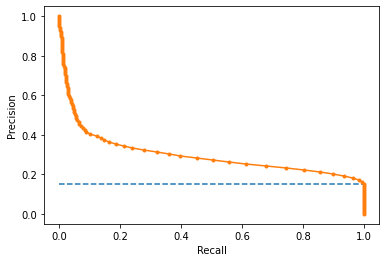

PR AUC=0.300


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from numpy.random import seed
seed(1)

ann1 = Sequential()
#input layer
ann1.add(Dense(100, activation='relu', input_dim=68))

#1st hidden layer
ann1.add(Dense(50, activation='relu'))
#2nd hidden layer
ann1.add(Dense(30, activation='relu'))

#3rd hidden layer
ann1.add(Dense(20, activation='relu'))

#4th hidden layer
ann1.add(Dense(10, activation='relu'))

#5th hidden layer
ann1.add(Dense(5, activation='relu'))

#output layer
ann1.add(Dense(1, activation='sigmoid'))

ann1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ann1.summary()

ANN(ann1,10,100)  #epochs=10 batch_size=100

Epoch 1/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3645 - accuracy: 0.8560
Epoch 2/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3624 - accuracy: 0.8570
Epoch 3/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3613 - accuracy: 0.8572
Epoch 4/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3610 - accuracy: 0.8579
Epoch 5/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3593 - accuracy: 0.8580
Epoch 6/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3580 - accuracy: 0.8587
Epoch 7/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3574 - accuracy: 0.8588
Epoch 8/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3566 - accuracy: 0.8589
Epoch 9/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3559 - accuracy: 0.8591
Epoch 10/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3542 - accuracy: 0.8595

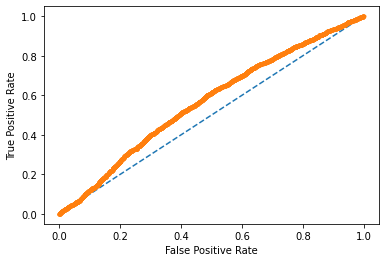

pr_auc=0.069


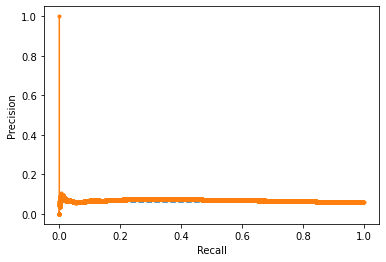

In [ ]:
scaler = MinMaxScaler()
X_s = scaler.fit_transform(X)
X_oot_s = scaler.transform(X_oot)
ann1.fit(X_s, y, epochs=10, batch_size=100)
y_oot_pred = ann1.predict_proba(X_oot_s) # y_pred 
roc_pr(y_oot,y_oot_pred)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               6900      
_________________________________________________________________
dense_8 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_10 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

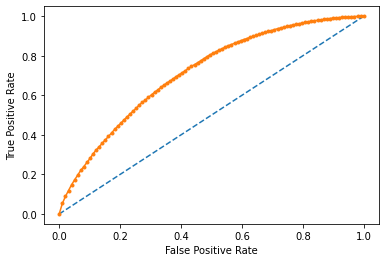

ROC AUC=0.716


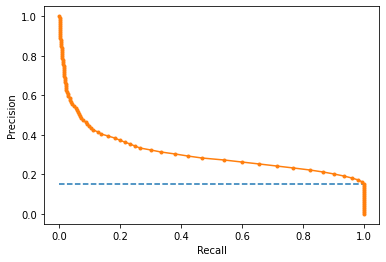

PR AUC=0.308


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from numpy.random import seed
seed(1)

ann2 = Sequential()
#input layer
ann2.add(Dense(100, activation='relu', input_dim=68))
#1st hidden layer
ann2.add(Dense(80, activation='relu'))

#2nd hidden layer
ann2.add(Dense(30, activation='relu'))

#3rd hidden layer
ann2.add(Dense(20, activation='relu'))

#4th hidden layer
ann2.add(Dense(10, activation='relu'))

#5th hidden layer
ann2.add(Dense(5, activation='relu'))

#output layer
ann2.add(Dense(1, activation='sigmoid'))
ann2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ann2.summary()

ANN(ann2,10,100) #epochs=10 and batch_size=100

Epoch 1/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3347 - accuracy: 0.8652
Epoch 2/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3324 - accuracy: 0.8658
Epoch 3/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3316 - accuracy: 0.8657
Epoch 4/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3296 - accuracy: 0.8669
Epoch 5/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3283 - accuracy: 0.8674
Epoch 6/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3274 - accuracy: 0.8678
Epoch 7/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3259 - accuracy: 0.8689
Epoch 8/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3243 - accuracy: 0.8698
Epoch 9/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3234 - accuracy: 0.8692
Epoch 10/10
991/991 [==============================] - 2s 2ms/step - loss: 0.3216 - accuracy: 0.8706

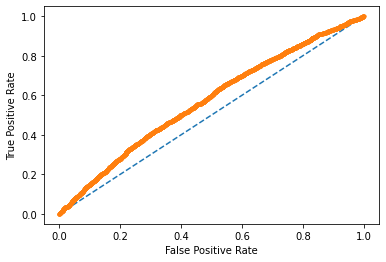

ROC AUC=0.572


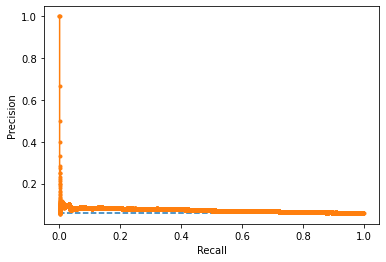

PR AUC=0.074


In [ ]:
scaler = MinMaxScaler()
X_s = scaler.fit_transform(X)
X_oot_s = scaler.transform(X_oot)
ann2.fit(X_s, y, epochs=10, batch_size=100)
y_oot_pred = ann2.predict_proba(X_oot_s) # y_pred 
roc_pr(y_oot,y_oot_pred)

### SHAP

In [17]:
# Split the data into train and test data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Build the model
gb = GradientBoostingClassifier(n_estimators=100, max_depth=4,random_state=42) #gradient boosting
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [18]:
!pip install shap

     |████████████████████████████████| 327kB 5.7MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463917 sha256=b108bff78964dc3144973512c978c6084dcf6f0c82df1f8ffba5f31f78ec65e4
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


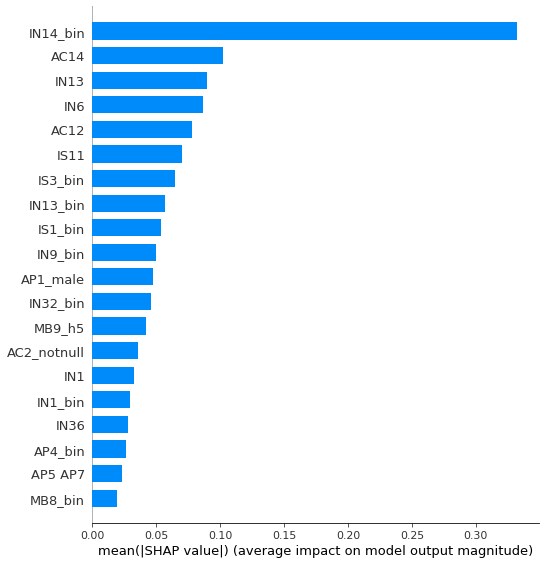

In [19]:
import shap
shap_values = shap.TreeExplainer(gb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

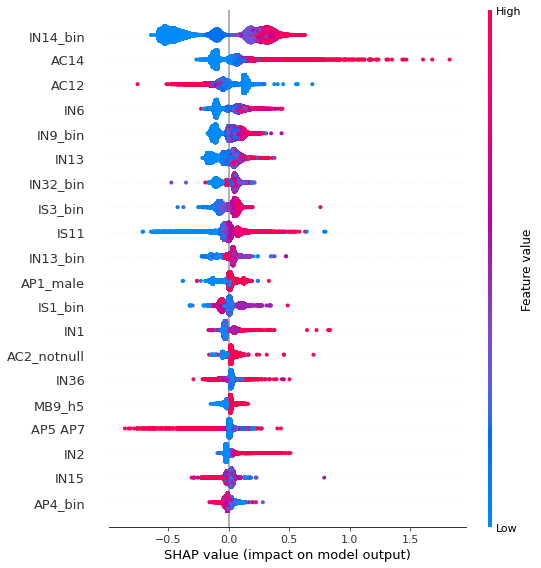

In [22]:
f = plt.figure()
shap.summary_plot(shap_values, X_train)

In [21]:
#use shap value to analyze a single client
shap.initjs()
explainerModel = shap.TreeExplainer(gb)
shap.force_plot(explainerModel.expected_value, explainerModel.shap_values(X_test)[5], X_test.iloc[[5]])

In [23]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(gb.predict_proba(X_output)[:,1],2)

# Randomly pick some observations
random_picks = np.arange(1,10000,100) # Every 50 rows
S = X_output.iloc[random_picks]
S

,AC7,AC11,AC12,AC14,IN1,IN2,IN6,IN13,IN15,IN16,IN27,IN29,IN30,IN36,P11,P13,P42,P46,P49,P50,P76,P79,P85,P92,P121,P123,P125,P157,P165,IS2,IS8,IS11,MB2,MB13,MB9_h5,IS9_1.0,IS9_4.0,AC2_0.0,AC2_2.0,AC2_1.0,AC2_5.0,AC3_8.0,AC3_1.0,AC3_0.0,AP1_male,MB12_wifi,AP4_bin,AC14_bin,IN1_bin,IN3_bin,IN5_bin,IN9_bin,IN13_bin,IN14_bin,IN17_bin,IN32_bin,P4_bin,P8_bin,IS1_bin,IS3_bin,MB8_bin,AC2_notnull,AC11_notnull,AC12_notnull,IN17_notnull,P1_notnull,MB8_notnull,AP5 AP7,predict
18769,92.0,121.0,13648.0,9527.0,1.0,0.0,2.0,2.0,5.0,0.0,11.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2131.511162,2207.650273,1964.650143,6.398947e+10,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2,0,0,0,0,1,3,2,7,0,0,4,8,2,1,1,1,1,0,0,2968.0,0.13
74610,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2058.242843,2037.218413,1825.409990,6.398947e+10,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9,0,0,0,0,0,0,0,0,0,0,0,2,1,2,0,1,1,0,0,0,0.0,0.04
76851,0.0,5.0,229688.0,170762.0,2.0,2.0,2.0,5.0,4.0,0.0,3.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1903.803582,2090.418913,1321.828761,6.393704e+10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8,5,1,0,3,3,3,1,2,2,0,0,1,4,4,1,1,1,1,0,1,0.0,0.17
70990,0.0,2.0,17000.0,17000.0,1.0,1.0,2.0,3.0,3.0,0.0,6.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2697.487158,2546.666667,2337.257902,6.398947e+10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6,3,0,0,0,2,2,2,0,4,0,0,7,5,2,0,1,1,1,0,0,0.0,0.16
30106,0.0,3.0,3800.0,0.0,2.0,0.0,0.0,3.0,3.0,0.0,3.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1978.138758,2090.981644,2595.552180,6.398947e+10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0,1,0,1,2,2,0,0,2,0,0,4,4,2,1,1,1,1,0,0,0.0,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28515,217.0,6.0,10000.0,2851.0,2.0,0.0,0.0,8.0,4.0,0.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2222.222222,2045.475775,2272.056897,1.279895e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6,1,1,0,1,3,5,2,0,1,0,0,7,4,1,1,1,1,1,1,1,8284.0,0.19
2166,1442.0,33.0,73232.0,2310.0,1.0,0.0,0.0,3.0,6.0,0.0,3.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2131.511162,2231.075697,1929.344498,1.279895e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,0,0,1,1,2,1,0,2,0,0,4,7,4,1,1,1,1,0,1,17020.0,0.11
4629,7506.0,15.0,260648.0,135989.0,0.0,0.0,1.0,3.0,5.0,0.0,4.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1978.138758,1997.716895,2019.740941,6.398947e+10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,5,0,0,0,2,2,1,0,3,0,0,4,7,2,1,1,1,1,0,0,669.0,0.18
73197,3721.0,7.0,129324.0,26036.0,3.0,1.0,1.0,8.0,4.0,0.0,3.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1797.763006,1764.314248,1950.488302,6.398947e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5,3,2,2,4,3,5,2,0,6,0,0,2,7,3,1,1,1,1,1,1,12080.0,0.19


In [ ]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(gb)
    shap_values_Model = explainerModel.shap_values(X_test)
    # print(shap_values_Model[j])
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_test.iloc[[j]])
    # shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])
    return(p)

In [ ]:
X_test.head(1)

,AP1,AC2,AC3,AC7,AC11,AC12,AC14,IN1,IN2,IN6,IN14,IN16,IN29,P4,P11,P13,P42,P46,P49,P50,P76,P79,P85,P92,P121,P123,P125,P157,P165,IS2,IS3,IS8,IS9,IS11,MB2,MB8,MB13,MB9_h5,AP3_bin,AP4_bin,AP5_bin,AC1_bin,AC11_bin,AC13_bin,AC14_bin,IN1_bin,IN3_bin,IN4_bin,IN5_bin,IN9_bin,IN13_bin,IN14_bin,IN16_bin,IN18_bin,IN23_bin,IN28_bin,IN31_bin,IN32_bin,IN33_bin,P4_bin,IS1_bin,IS3_bin,IS6_bin,MB11_bin,AC2_notnull,IN1_notnull,AP4 AP7,AP5 AP7
91559,0.0,8.0,6.0,0.0,1.0,45402.0,18290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2292.367629,2163.220036,2055.961071,3.0,2115.266859,6.398947e+10,3848.0,0.0,1.0,10,9,4,0,0,0,1,0,0,0,0,0,0,0,0,3,5,6,10,10,7,3,5,4,1,10,0,1,0.0,0.0


In [ ]:
#example of examining a single applicant
shap.initjs()
shap_plot(0)

In [ ]:
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X)
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
explainer.expected_value
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

Exception: ignored

### Demographic Analysis

In [44]:
def tuning_oversampling(X,y,model, parameters,over_method):
  roc=[]
  tprs = []
  pr=[]
  prs = []
  mean_fpr = np.linspace(0,1,100)
  mean_precision = np.linspace(0,1,100)
  i=1
  skf=StratifiedKFold(n_splits=5,random_state=42)
  skf.get_n_splits(X,y)

  for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y.iloc[train_index], y.iloc[test_index]
    
    over = over_method(sampling_strategy=0.5,random_state=42)
    X_train_over, y_train_over = over.fit_resample(X_train, y_train)
    X_train_over=pd.DataFrame(X_train_over)
    y_train_over=pd.DataFrame(y_train_over)

    #model
    clf = GridSearchCV(model,scoring='roc_auc', param_grid=parameters, cv=2)
    clf.fit(X_train_over, y_train_over)
    print("best parameters: {}".format(clf.best_params_))
    clf_proba=clf.predict_proba(X_test)[:,1]

    #roc_auc score
    roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
    clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
    prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
    pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
    clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
    tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))


    print('ROC AUC score:',roc_score)
    print('PR AUC score:',pr_score)
    roc.append(roc_score)
    pr.append(pr_score)
    i+=1


  print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
  ns_probs = [0 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  mean_fpr=np.linspace(0,1,100)
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  # show the plot
  plt.show()
  # summarize scores
  print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 
 

  mean_precision = np.linspace(0,1,100)
  mean_recall = np.mean(prs, axis=0)
  mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  # show the plot
  plt.show()
  # summarize scores
  print('PR AUC=%.3f' % (mean_auc))

In [38]:
# get data of 2 genders 
male_oot=oot[oot.AP1_male==1]
female_oot=oot[oot.AP1_male==0]

male_selected=selected[selected.AP1_male==1]
female_selected=selected[selected.AP1_male==0]

In [39]:
print(female_oot.label.sum()/female_oot.shape[0])
print(male_oot.label.sum()/male_oot.shape[0])

0.0545005535212467
0.06008052028491793


In [40]:
female_oot_y = female_oot['label']
female_oot_X = female_oot.drop(columns=['applied_id','label'])
male_oot_y = male_oot['label']
male_oot_X = male_oot.drop(columns=['applied_id','label'])

female_selected_y = female_selected['label']
female_selected_X = female_selected.drop(columns=['applied_id','label'])
male_selected_y = male_selected['label']
male_selected_X = male_selected.drop(columns=['applied_id','label'])

1 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.7370710655271372
PR AUC score: 0.25613724851341296
2 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.7345882644628099
PR AUC score: 0.2588486277783904
3 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.7282368562564633
PR AUC score: 0.25393806708404715
4 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.7353330299896588
PR AUC score: 0.2669990106956464
5 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.7451520992761116
PR AUC score: 0.2702714935464171
Mean ROC AUC Score 0.736 
Mean PR AUC Score 0.261


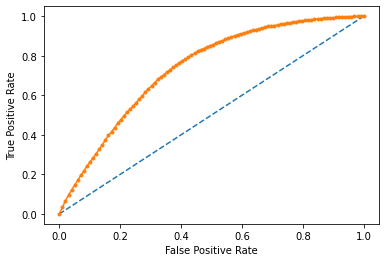

ROC AUC=0.736


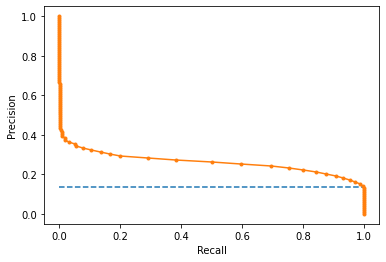

PR AUC=0.262


In [46]:
parameters= {'n_estimators': range(20,140,20),'max_depth':[3,4,5]}
model=GradientBoostingClassifier()
tuning_oversampling(female_selected_X,female_selected_y,model, parameters,SMOTE)

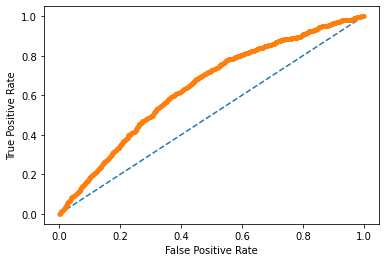

ROC AUC=0.643


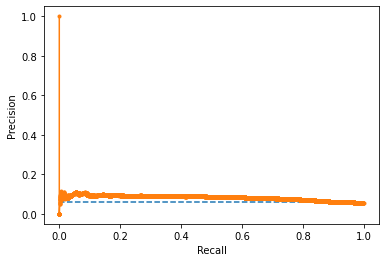

PR AUC=0.083


In [47]:
gbm = GradientBoostingClassifier(max_depth=5,n_estimators=40).fit(female_selected_X, female_selected_y)
female_y_pred = gbm.predict_proba(female_oot_X)[:, 1] # y_pred 
roc_pr(female_oot_y,female_y_pred)

1 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.6607376290035913
PR AUC score: 0.26036321091707954
2 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 20}
ROC AUC score: 0.647374077500896
PR AUC score: 0.23726186757462364
3 of KFold 5
best parameters: {'max_depth': 4, 'n_estimators': 40}
ROC AUC score: 0.647045661021702
PR AUC score: 0.2418930098378654
4 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 20}
ROC AUC score: 0.6396198559632672
PR AUC score: 0.23421077593635747
5 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 20}
ROC AUC score: 0.6496299296261265
PR AUC score: 0.24152926493858787
Mean ROC AUC Score 0.649 
Mean PR AUC Score 0.243


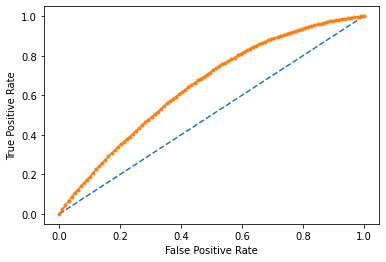

ROC AUC=0.649


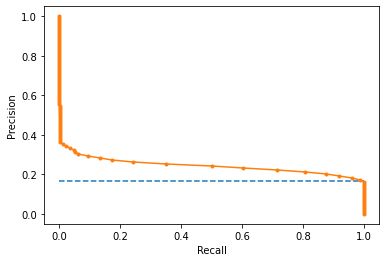

PR AUC=0.244


In [48]:
parameters= {'n_estimators': range(20,140,20),'max_depth':[3,4,5]}
model=GradientBoostingClassifier()
tuning_oversampling(male_selected_X,male_selected_y,model, parameters,SMOTE)

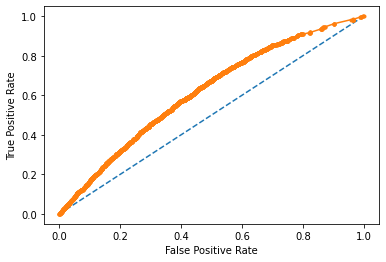

ROC AUC=0.617


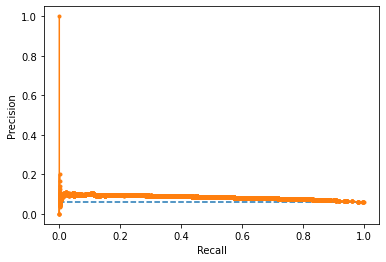

PR AUC=0.084


In [49]:
gbm = GradientBoostingClassifier(max_depth=5,n_estimators=20).fit(male_selected_X, male_selected_y)
male_y_pred = gbm.predict_proba(male_oot_X)[:, 1] # y_pred 
roc_pr(male_oot_y,male_y_pred)

In [50]:
# get data of 3 age groups
#20-26 
age_20_26_oot=oot.loc[oot['AP4_bin'].isin([0,1,2])]
#27-30
age_27_30_oot=oot.loc[oot['AP4_bin'].isin([3,4,5])]
#31-51
age_31_51_oot=oot.loc[oot['AP4_bin'].isin([6,7,8,9])]


#20-26 
age_20_26_selected=selected.loc[selected['AP4_bin'].isin([0,1,2])]
#27-30
age_27_30_selected=selected.loc[selected['AP4_bin'].isin([3,4,5])]
#31-51
age_31_51_selected=selected.loc[selected['AP4_bin'].isin([6,7,8,9])]

In [51]:
print(age_20_26_oot.label.sum()/age_20_26_oot.shape[0])
print(age_27_30_oot.label.sum()/age_27_30_oot.shape[0])
print(age_31_51_oot.label.sum()/age_31_51_oot.shape[0])

0.07333747669359851
0.05573558003888529
0.05337943703063375


In [52]:
age_20_26_oot_y = age_20_26_oot['label']
age_20_26_oot_X = age_20_26_oot.drop(columns=['applied_id','label'])

age_27_30_y_oot = age_27_30_oot['label']
age_27_30_X_oot = age_27_30_oot.drop(columns=['applied_id','label'])

age_31_51_y_oot = age_31_51_oot['label']
age_31_51_X_oot = age_31_51_oot.drop(columns=['applied_id','label'])


age_20_26_y_selected = age_20_26_selected['label']
age_20_26_X_selected = age_20_26_selected.drop(columns=['applied_id','label'])

age_27_30_y_selected = age_27_30_selected['label']
age_27_30_X_selected = age_27_30_selected.drop(columns=['applied_id','label'])

age_31_51_y_selected = age_31_51_selected['label']
age_31_51_X_selected = age_31_51_selected.drop(columns=['applied_id','label'])

1 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.6436988195384105
PR AUC score: 0.24472436498344916
2 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.660168184129456
PR AUC score: 0.25791453696105693
3 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.6517471337116814
PR AUC score: 0.25233755784986744
4 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.6539916480476646
PR AUC score: 0.2548497475302006
5 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.6650050537291201
PR AUC score: 0.26710819090502474
Mean ROC AUC Score 0.655 
Mean PR AUC Score 0.255


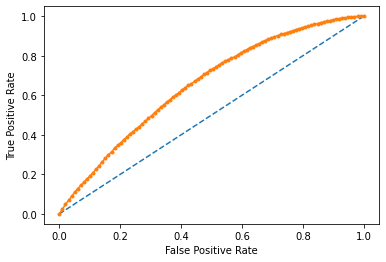

ROC AUC=0.655


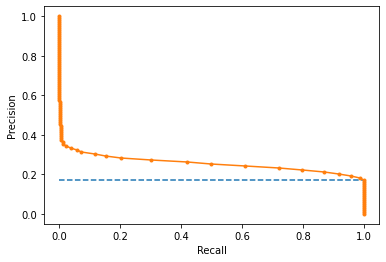

PR AUC=0.256


In [53]:
parameters= {'n_estimators': range(20,140,20),'max_depth':[3,4,5]}
model=GradientBoostingClassifier()
tuning_oversampling(age_20_26_X_selected,age_20_26_y_selected,model, parameters,SMOTE)

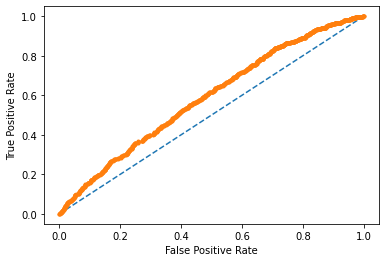

ROC AUC=0.589


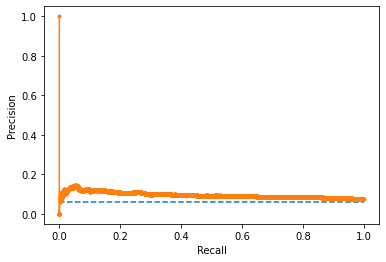

PR AUC=0.096


In [56]:
gbm = GradientBoostingClassifier(max_depth=5,n_estimators=40).fit(age_20_26_X_selected, age_20_26_y_selected)
age_20_26_y_pred = gbm.predict_proba(age_20_26_oot_X)[:, 1] # y_pred 
roc_pr(age_20_26_oot_y,age_20_26_y_pred)

1 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.7158223944297488
PR AUC score: 0.2857354551301653
2 of KFold 5
best parameters: {'max_depth': 4, 'n_estimators': 40}
ROC AUC score: 0.6849922500699297
PR AUC score: 0.24394664818655337
3 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.6856519532812254
PR AUC score: 0.24289557140763504
4 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.6940744059873568
PR AUC score: 0.2582938660256296
5 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.6939441107681679
PR AUC score: 0.2626539042090232
Mean ROC AUC Score 0.695 
Mean PR AUC Score 0.259


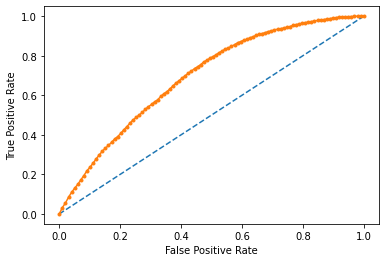

ROC AUC=0.695


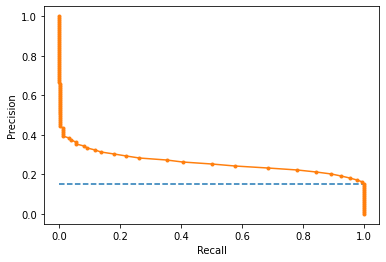

PR AUC=0.260


In [57]:
parameters= {'n_estimators': range(20,140,20),'max_depth':[3,4,5]}
model=GradientBoostingClassifier()
tuning_oversampling(age_27_30_X_selected,age_27_30_y_selected,model, parameters,SMOTE)

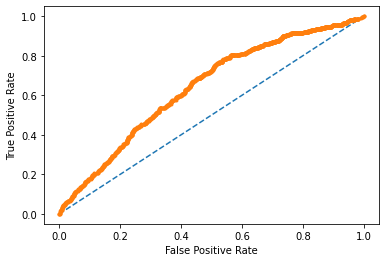

ROC AUC=0.641


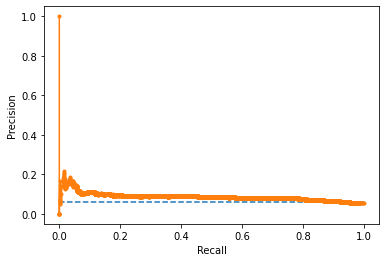

PR AUC=0.087


In [58]:
gbm = GradientBoostingClassifier(max_depth=5,n_estimators=40).fit(age_27_30_X_selected, age_27_30_y_selected)
age_27_30_y_pred = gbm.predict_proba(age_27_30_X_oot)[:, 1] # y_pred 
roc_pr(age_27_30_y_oot,age_27_30_y_pred)

1 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.7052696990467229
PR AUC score: 0.24571905598507626
2 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.7076980746007034
PR AUC score: 0.2400062708117165
3 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.6938418159634085
PR AUC score: 0.2454335165205317
4 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.7043565831585918
PR AUC score: 0.24944465373874655
5 of KFold 5
best parameters: {'max_depth': 5, 'n_estimators': 40}
ROC AUC score: 0.7070470667941973
PR AUC score: 0.23536824010980043
Mean ROC AUC Score 0.704 
Mean PR AUC Score 0.243


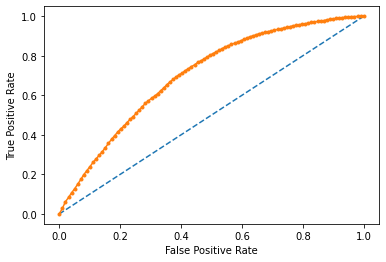

ROC AUC=0.704


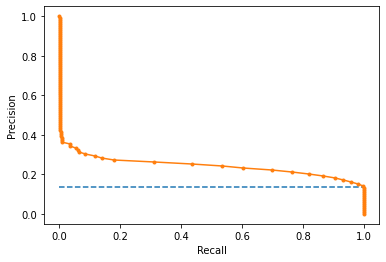

PR AUC=0.244


In [59]:
parameters= {'n_estimators': range(20,140,20),'max_depth':[3,4,5]}
model=GradientBoostingClassifier()
tuning_oversampling(age_31_51_X_selected,age_31_51_y_selected,model, parameters,SMOTE)

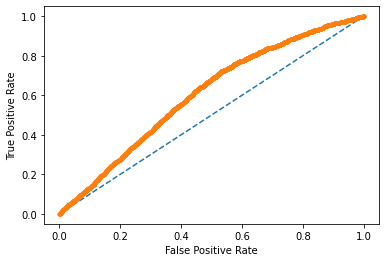

ROC AUC=0.606


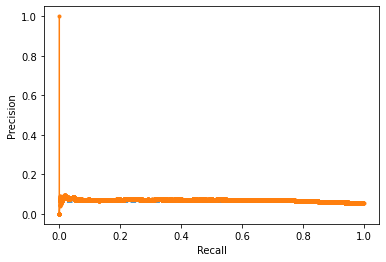

PR AUC=0.070


In [61]:
gbm = GradientBoostingClassifier(max_depth=5,n_estimators=40).fit(age_31_51_X_selected, age_31_51_y_selected)
age_31_51_y_pred = gbm.predict_proba(age_31_51_X_oot)[:, 1] # y_pred 
roc_pr(age_31_51_y_oot,age_31_51_y_pred)